In [1]:
import numpy as np
from numpy.linalg import norm
from itertools import combinations

# def foo(Q):
#     _, k = Q.shape
#     res = np.zeros_like(Q)
#     q = Q[:, 0]
#     print(q)
#     res[:, 0] =  q / norm(q)
#     res[0, 0] = 1
#     print(res)

#     for i in range(1, k):
#         O_i = res[:, :i]
#         q = Q[:, i]
#         print(q)
#         q_orth = q - O_i.dot(O_i.T.dot(q))
#         res[:, i] =  q_orth / norm(q_orth)
#     return res

def orthonormalization(Q):
    n, k = Q.shape
    O = np.zeros(shape=(n, k))
    q = Q[:, 0]
    O[:, 0] =  q / norm(q)

    for i in range(1, k):
        O_i = O[:, :i]
        q = Q[:, i]
        q_orth = q - O_i.dot(O_i.T.dot(q))
        O[:, i] =  q_orth / norm(q_orth)
    return O

def non_empty_subset_indicator(d, idx=None):
    idx = np.arange(d) if idx is None else idx
    for l in range(1, len(idx)+1):
        for c in combinations(idx, l):
            col = np.zeros(d)
            col[list(c)] = 1
            yield col

class instance:

    @staticmethod
    def random(n, t, seed=None):
        rng = np.random.default_rng(seed)
        Q = rng.binomial(1, 0.5, size=(n, t))
        g = rng.normal(size=n)
        return instance(Q, g)

    def __init__(self, Q, g, keep_bf_queries=False):
        n, k = Q.shape
        self.n = n
        self.k = k
        self.Q = Q
        self.O = orthonormalization(Q)
        self.g = g
        self.P = self.O.dot(self.O.T)
        self.M = np.eye(n) - self.P
        self.g = self.M.dot(g)
        self.keep_bf_queries = keep_bf_queries

    def orth_part_norm(self, queries):
        return norm(self.M.dot(queries))

    def selected_grad_elements(self, q):
        return np.sort(self.g[np.flatnonzero(q)])

class result:

    def __init__(self, q_star, f_star, q_seq, inst):
        self.q_star = q_star
        self.f_star = f_star
        self.q_seq = q_seq
        self.inst = inst

    def print_selected_elements_by_score(self, q=None, score=None, end='\n', sep=' '):
        q = self.q_star if q is None else q
        score = self.inst.g if score is None else score
        order = np.argsort(score)[::-1]
        for i in range(self.inst.n):
            s = f'\x1b[31m{score[order[i]]:.3f}\x1b[0m' if q[order[i]] else f'{score[order[i]]:.3f}'
            print(s, end=sep if i<self.inst.n-1 else '')
        print(end, end='')

def brute_force(self, epsilon=0):
    if self.keep_bf_queries:
        bf_queries = np.zeros(shape=(2**self.n-1, self.n))
    bf_gsum_ = np.zeros(2**self.n-1)
    bf_opn_ = np.zeros(2**self.n-1)
    bf_norms_ = np.zeros(2**self.n-1)

    i_star = -1
    obj_star = float('-inf')
    q_star = None

    for i, q in enumerate(non_empty_subset_indicator(self.n)):
        if self.keep_bf_queries:
            bf_queries[i, :] = q
        bf_gsum_[i]=self.g.dot(q)
        bf_opn_[i]=self.orth_part_norm(q)
        bf_norms_[i]=norm(q)
        
        obj = (bf_gsum_[i]**2 / (bf_opn_[i] + epsilon)**2) if epsilon!=0 or bf_opn_[i]>1e-5 else 0
        if obj > obj_star:
            i_star = i
            q_star = q
            obj_star = obj

    res = result(q_star, obj_star, bf_queries if self.keep_bf_queries else None, self)
    res.i_star = i_star
    res.gsums = bf_gsum_
    res.op_norms = bf_opn_
    res.norms = bf_norms_

    return res

    


### Objective Function is Bounded by Squared Norm of Gradient

We can bound the objective function by decomposing $q_\perp$ into components parallel and orthogonal to the gradient vector, i.e.,
\begin{equation*}
q_\perp = q_{\perp\parallel} + q_{\perp\perp}\\
\end{equation*}
where
\begin{equation*}
q_{\perp\parallel} = \frac{q_\perp^Tg}{\|g\|^2}g \enspace .
\end{equation*}

Indeed, by observing that $\|q_{\perp\parallel}\|^2=(g^Tq)^2/\|g\|^2$ we can conclude that
\begin{align*}
\frac{(g^Tq)^2}{\|q_\perp\|^2} &= \frac{(g^Tq)^2}{\|q_{\perp\parallel}\|^2 + \|q_{\perp\perp}\|^2}\\
&\leq \frac{(g^Tq)^2}{\|q_{\perp\parallel}\|^2}\\
&=\|g\|^2
\end{align*}


In [2]:
import numpy as np
from numpy.linalg import norm

RNG = np.random.default_rng(1000)
Q = RNG.binomial(1, 0.5, size=(20, 10))
g = RNG.normal(size=20)
inst1 = instance(Q[:, :5], g)

In [3]:
res = brute_force(inst1)
res.f_star, norm(inst1.g)**2

(8.538267131385675, 10.75480867024855)

In [4]:
res.print_selected_elements_by_score()

1.330 1.120 0.915 0.906 0.832 0.595 0.143 0.130 0.013 -0.002 -0.137 -0.210 -0.390 -0.391 -0.490 -0.652 -0.764 -0.928 -1.015 -1.218


In [5]:
from matplotlib import pyplot as plt

def plot_solutions(res, additional_res=None, additional_res_names=None):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, tight_layout=True, squeeze=False)
    bf_obj_ = res.gsums**2 / res.op_norms**2
    axs[0, 0].scatter(res.norms**2, bf_obj_)
    axs[0, 1].scatter(res.op_norms**2, bf_obj_)
    axs[0, 2].scatter(res.gsums, bf_obj_)

    additional_res = [] if additional_res is None else additional_res
    additional_res_names = [f'$q_{i}$' for i in range(len(additional_res))]
    all_results = [res] + additional_res
    all_result_names = [r'$q^*$'] + additional_res_names
    all_res_colors = ['red', 'lime', 'gold', 'magenta', 'black', 'gray'][:len(all_results)]
    for res, name, color in zip(all_results, all_result_names, all_res_colors):
        axs[0, 0].scatter(norm(res.q_star)**2, res.f_star, edgecolors=color, facecolors='none', label=name)
        axs[0, 1].scatter(norm(res.inst.M.dot(res.q_star))**2, res.f_star, edgecolors=color, facecolors='none')
        axs[0, 2].scatter(res.q_star.dot(res.inst.g), res.f_star, edgecolors=color, facecolors='none')
    axs[0, 0].set_ylabel(r'$(q^Tg)^2/\|q_\perp\|^2$')
    axs[0, 0].set_xlabel(r'$\|q\|^2$')
    axs[0, 1].set_xlabel(r'$\|q_\perp\|^2$')
    axs[0, 2].set_xlabel(r'$q^Tg$')
    axs[0, 0].axhline(norm(res.inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 1].axhline(norm(res.inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 2].axhline(norm(res.inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 0].legend(loc='upper right')

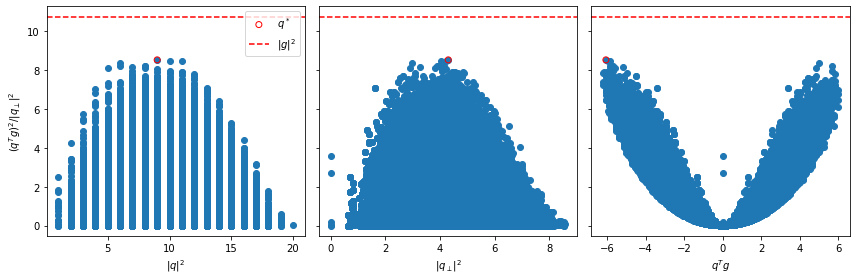

In [6]:
plot_solutions(res)

### More Systematic Test

In [7]:
smaller_instances = []
num_instances = 2000
def brute_force_test(epsilon=0):
#     smaller_instances_bf_res = []
    smaller_instances_bf_f_stars=np.array([])
    for i in range(num_instances):
        inst = instance.random(15, 5, i)
        res = brute_force(inst, epsilon=epsilon)
#         print(i, end='. ')
#         res.print_selected_elements_by_score(end=': ')
#         print(f'{inst.g.dot(res.q_star):.3f}', f'{res.f_star: .3f}')
        smaller_instances.append(inst)
#         smaller_instances_bf_res.append(res)
        smaller_instances_bf_f_stars = np.append(smaller_instances_bf_f_stars, res.f_star)
    return smaller_instances_bf_f_stars

In [8]:
bfe0f = brute_force_test(epsilon=0)

In [9]:
bfe1e_3f = brute_force_test(epsilon=1e-3)

In [10]:
bfe1e_2f = brute_force_test(epsilon=1e-2)

In [11]:
bfe1e_1f = brute_force_test(epsilon=1e-1)

In [12]:
bfe1f = brute_force_test(epsilon=1)

In [13]:
bfe10f = brute_force_test(epsilon=10)

## Greedy Performance

In [14]:
def squared_grad_sum_by_squared_orth_norm(q, inst, epsilon):
    d = norm(inst.M.dot(q))
    return (q.dot(inst.g)**2/(norm(inst.M.dot(q)) + epsilon)**2) if epsilon!=0 or d>1e-5 else 0

def best_in_greedy(inst, epsilon=0, f = squared_grad_sum_by_squared_orth_norm):
    seq = np.zeros(shape=(inst.n+1, inst.n))
    objs = np.zeros(inst.n+1)
    for i in range(1, inst.n+1):
        seq[i, :] = np.copy(seq[i-1, :])
        j_star = -1
        obj_star = float('-inf')
        for j in range(inst.n):
            if seq[i, j]: continue    
            seq[i, j] = 1
            obj = f(seq[i, :], inst, epsilon=epsilon)
            if obj > obj_star:
                j_star = j
                obj_star = obj
            seq[i, j] = 0
        seq[i, j_star] = 1
        objs[i] = obj_star
#         print(seq[i, :])
#     print(objs)
    best_idx = np.argmax(objs)    
    return result(seq[best_idx, :], objs[best_idx], seq, inst)

In [15]:
smaller_instances_greedy_res = []
smaller_instances_greedy_f_stars=np.array([])
for i in range(num_instances):
    inst = smaller_instances[i]
    res = best_in_greedy(inst)
#     res.print_selected_elements_by_score(end=': ')
#     print(f'{inst.g.dot(res.q_star):.3f}', f'{res.f_star: .3f}')
    smaller_instances_greedy_res.append(res)
    smaller_instances_greedy_f_stars = np.append(smaller_instances_greedy_f_stars, res.f_star)

Comparing the greedy solution to the optimal solution on our first instance, we say that the greedy algorithm "picked the wrong horse": based on a good objective value for a positive gradient element, it started to grow a solution with positive sum of selected gradient elements whereas the optimum solution selects a negative sum.

### Refined Greedy Strategy with "Signed" Objectives

This suggest to a refined greedy approach to find the optimal solution that runs the greedy algorithm twice, once aiming to find the optimal "positive solution" and once the optimal "negative solution".

Indeed, when working with the non-squared objective function, we can easily split it into a positive and negative part
\begin{equation*}
\max_{q \in {\cal Q}} \frac{|g^Tq|}{\|q_\perp\|} = \max \left\{\max_{q \in {\cal Q}} \frac{g^Tq}{\|q_\perp\|}, \max_{q \in {\cal Q}}\frac{-g^Tq}{\|q_\perp\|} \right\}
\end{equation*}

In [16]:
def grad_sum_by_orth_norm(q, inst, epsilon):
    d = norm(inst.M.dot(q))
    return (q.dot(inst.g)/(norm(inst.M.dot(q)) + epsilon)) if epsilon!=0 or d>1e-5 else 0

def neg_grad_sum_by_orth_norm(q, inst, epsilon):
    d = norm(inst.M.dot(q))
    return (-q.dot(inst.g)/(norm(inst.M.dot(q)) + epsilon)) if epsilon!=0 or d>1e-5 else 0

In [17]:
def best_in_greedy_pos_neg(inst, epsilon=0):
    pos = best_in_greedy(inst, epsilon=epsilon, f=grad_sum_by_orth_norm)
    neg = best_in_greedy(inst, epsilon=epsilon, f=neg_grad_sum_by_orth_norm)
    if pos.f_star > neg.f_star:
        res = pos
    else:
        res = neg
    res.f_star = res.f_star**2
    return res

In [18]:
def greedy_pos_neg_test(epsilon=0):
#     smaller_instances_pn_res = []
    smaller_instances_pn_f_stars = np.array([])
    for i in range(num_instances):
        inst = smaller_instances[i]
        res = best_in_greedy_pos_neg(inst, epsilon=epsilon)
#         res.print_selected_elements_by_score(end=': ')
#         print(f'{inst.g.dot(res.q_star):.3f}', f'{res.f_star: .3f}')
#         smaller_instances_pn_res.append(res)
        smaller_instances_pn_f_stars = np.append(smaller_instances_pn_f_stars, res.f_star)
    return smaller_instances_pn_f_stars

In [19]:
gpne0f = greedy_pos_neg_test(epsilon=0)

In [20]:
gpne1e_3f = greedy_pos_neg_test(epsilon=1e-3)

In [21]:
gpne1e_2f = greedy_pos_neg_test(epsilon=1e-2)

In [22]:
gpne1e_1f = greedy_pos_neg_test(epsilon=1e-1)

In [23]:
gpne1f = greedy_pos_neg_test(epsilon=1)

In [24]:
gpne10f = greedy_pos_neg_test(epsilon=10)

In [25]:
def fast_para_norms_prefix(O, ext):
    deltas = O[ext]
    length = len(ext)
    okqi = np.cumsum(deltas, axis=0)
    q_para_norms = (okqi ** 2).sum(axis=1)
    q_orth_norms_sq = np.abs(np.arange(1, length + 1) - q_para_norms)
    q_orth_norms = np.sqrt(q_orth_norms_sq)
    return q_orth_norms


def pre_order_greedy(inst, epsilon=0, f = squared_grad_sum_by_squared_orth_norm):
    seq = np.zeros(shape=(inst.n+1, inst.n))
    objs = np.zeros(inst.n+1)
    order = np.argsort(inst.g)
    g = inst.g[order]
    O = inst.O[order]
    num_pre = abs(np.cumsum(g))
    num_suf = abs(np.cumsum(g[::-1]))
    ext = np.arange(inst.n)
    qs = fast_para_norms_prefix(O, ext) + epsilon
    qs_neg = fast_para_norms_prefix(O, ext[::-1]) + epsilon
    neg_bounds = np.divide(num_suf, qs_neg, out=np.zeros_like(num_suf), where=qs_neg != 0)
    pos_bounds = np.divide(num_pre, qs, out=np.zeros_like(num_suf), where=qs != 0)
    neg_max = np.argmax(neg_bounds)
    pos_max = np.argmax(pos_bounds)
#     print(pos_bounds)
#     print(neg_bounds)
    if neg_bounds[neg_max]>pos_bounds[pos_max]:
        best_seq = np.zeros(inst.n)
        selected = np.arange(0, neg_max+1)
        best_seq[order[selected]]=1
        obj = neg_bounds[neg_max]
    else:
        best_seq = np.zeros(inst.n)
        selected = np.arange(0, pos_max+1)
        best_seq[order[::-1][selected]]=1
        obj = pos_bounds[pos_max]
    return result(best_seq, obj**2, seq, inst)

In [26]:
def pre_order_greedy_test(epsilon=0):
#     smaller_instances_pre_res = []
    smaller_instances_pre_f_stars = np.array([])
    for i in range(num_instances):
        inst = smaller_instances[i]
        res = pre_order_greedy(inst, epsilon=epsilon)
#         res.print_selected_elements_by_score(end=': ')
#         print(i, f'{inst.g.dot(res.q_star):.3f}', f'{res.f_star: .3f}')
#         smaller_instances_pre_res.append(res)
        smaller_instances_pre_f_stars = np.append(smaller_instances_pre_f_stars, res.f_star)
    return smaller_instances_pre_f_stars

In [27]:
pree0f = pre_order_greedy_test(epsilon=0)

In [28]:
pree1e_3f = pre_order_greedy_test(epsilon=1e-3)

In [29]:
pree1e_2f = pre_order_greedy_test(epsilon=1e-2)

In [30]:
pree1e_1f = pre_order_greedy_test(epsilon=1e-1)

In [31]:
pree1f = pre_order_greedy_test(epsilon=1)

In [32]:
pree10f = pre_order_greedy_test(epsilon=10)

In [33]:
ratio_pn0 = gpne0f / bfe0f
ratio_pre0 = pree0f / bfe0f
ratio_pn0, ratio_pre0

(array([1.       , 1.       , 1.       , ..., 1.       , 0.9505098,
        1.       ]),
 array([1.        , 0.98281094, 0.94871012, ..., 1.        , 0.9505098 ,
        0.96073593]))

In [34]:
ratio_pn1e_3 = gpne1e_3f / bfe1e_3f
ratio_pre1e_3 = pree1e_3f / bfe1e_3f
ratio_pn1e_3, ratio_pre1e_3

(array([1.       , 1.       , 1.       , ..., 1.       , 0.9508653,
        1.       ]),
 array([1.        , 0.9829129 , 0.94888191, ..., 1.        , 0.9508653 ,
        0.96123492]))

In [35]:
ratio_pn1e_2 = gpne1e_2f / bfe1e_2f
ratio_pre1e_2 = pree1e_2f / bfe1e_2f
ratio_pn1e_2, ratio_pre1e_2

(array([1.        , 1.        , 1.        , ..., 1.        , 0.95404836,
        1.        ]),
 array([1.        , 0.98382583, 0.95042159, ..., 1.        , 0.95404836,
        0.96571204]))

In [36]:
ratio_pn1e_1 = gpne1e_1f / bfe1e_1f
ratio_pre1e_1 = pree1e_1f / bfe1e_1f
ratio_pn1e_1, ratio_pre1e_1

(array([1.        , 1.        , 1.        , ..., 1.        , 0.98432669,
        0.99092552]),
 array([1.        , 0.99251904, 0.96520381, ..., 1.        , 0.98432669,
        1.        ]))

In [37]:
ratio_pn1 = gpne1f / bfe1f
ratio_pre1 = pree1f / bfe1f
ratio_pn1, ratio_pre1

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1.        , 1.        , 1.        , ..., 0.97513396, 1.        ,
        1.        ]))

In [38]:
ratio_pn10 = gpne10f / bfe10f
ratio_pre10 = pree10f / bfe10f
ratio_pn10, ratio_pre10

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1.        , 1.        , 1.        , ..., 0.97813932, 1.        ,
        1.        ]))

In [39]:
kwargs = dict(width=0.25/20)

/tmp/ipykernel_10771/1297173853.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, i].set_yticklabels(['%1.1f%%' %i for i in vals])


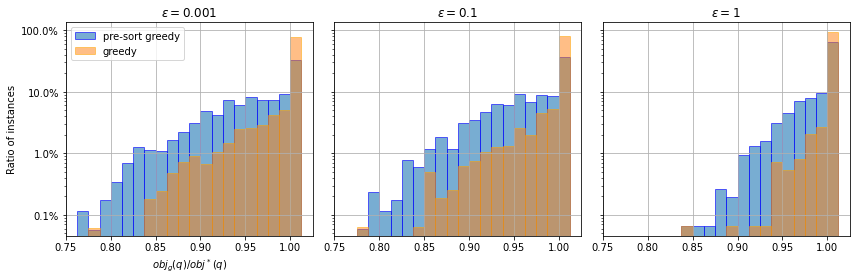

In [84]:
from matplotlib import pyplot as plt

def plot_hists(res_pns, res_pres, filename):
    heights_pres=[]
    heights_pns=[]
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True, tight_layout=True, squeeze=False)
    for i in range(3):
        heights_pre, bins = np.histogram(res_pres[i], 20, range=(0.75, 1))
#         print(heights_pre/20, bins)
        heights_pn, _ = np.histogram(res_pns[i], bins)
        heights_pns.append(heights_pn)
        heights_pres.append(heights_pre)
        axs[0, i].bar(bins[1:], heights_pre/sum(heights_pre)*100, label = 'pre-sort greedy', edgecolor='blue', align="edge",alpha=0.6, **kwargs)
        axs[0, i].bar(bins[1:], heights_pn/sum(heights_pn)*100, label='greedy', align="edge", edgecolor='orange',alpha=0.5,  **kwargs)
        axs[0, i].grid()
        axs[0, i].set_yscale('log')
        vals = axs[0, i].get_yticks()
        axs[0, i].set_yticklabels(['%1.1f%%' %i for i in vals])
    axs[0, 0].set_xlabel(r"$obj_{g}(q)/obj^*(q)$")
    axs[0, 0].set_title(r"$\epsilon=0.001$")
    axs[0, 1].set_title(r"$\epsilon=0.1$")
    axs[0, 2].set_title(r"$\epsilon=1$")
    axs[0, 0].set_ylabel(r'Ratio of instances')
    axs[0, 0].legend(loc='upper left')
    fig.savefig(filename)
    return heights_pres, heights_pns
pre, pn=plot_hists([ratio_pn1e_3, ratio_pn1e_1, ratio_pn1], [ratio_pre1e_3, ratio_pre1e_1, ratio_pre1], filename='combined_greedy.pdf')

In [90]:
from IPython.display import display, Markdown
epsilons=[0.001, 0.1, 1]

output_string=rf"""
$\epsilon$ |pre-sort/obj*>=90%|greedy/obj*>=90%|pre-sort/obj*>=95%|greedy/obj*>=95%|pre-sort/obj*=100%|greedy/obj*=100%
---|---|---|---|---|---|---
"""
for i in range(3):
    output_string+=rf"""{epsilons[i] } | {sum(pre[i][-9:])/sum(pre[i])}|{sum(pn[i][-9:])/sum(pn[i])}|{sum(pre[i][-5:])/sum(pre[i])}|{sum(pn[i][-5:])/sum(pn[i])}|{sum(pre[i][-1:])/sum(pre[i])}|{sum(pn[i][-1:])/sum(pn[i])}|
    """
display(Markdown("The following table shows the ratios of instances where the pre-sort greedy / greedy reaches 90%, 95%, 100% of the optimal bounding values:"))
display(Markdown(output_string))

The following table shows the ratios of instances where the pre-sort greedy / greedy reaches 90%, 95%, 100% of the optimal bounding values:


$\epsilon$ |pre-sort/obj*>=90%|greedy/obj*>=90%|pre-sort/obj*>=95%|greedy/obj*>=95%|pre-sort/obj*=100%|greedy/obj*=100%
---|---|---|---|---|---|---
0.001 | 0.8811028144744399|0.9737484737484737|0.6553704767375071|0.9169719169719169|0.33199310740953475|0.7686202686202687|
    0.1 | 0.9079646017699115|0.9831038798498123|0.7014749262536873|0.9392991239048811|0.3687315634218289|0.7959949937421777|
    1 | 0.9933598937583001|0.9986693280106453|0.9243027888446215|0.9900199600798403|0.6328021248339973|0.929474384564205|
    

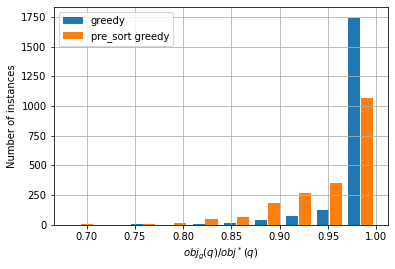

In [41]:
plt.hist([ratio_pn0, ratio_pre0], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn0.pdf")

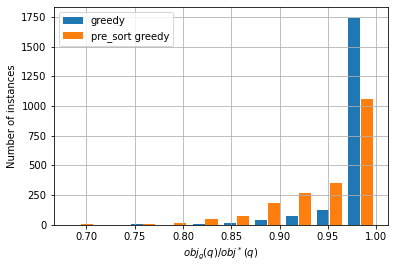

In [42]:
plt.hist([ratio_pn1e_3, ratio_pre1e_3], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn1e_3.pdf")

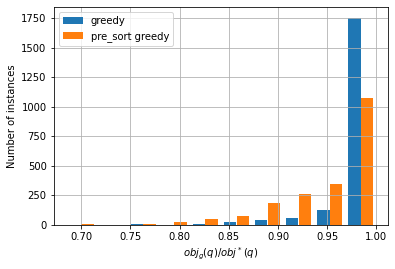

In [43]:
plt.hist([ratio_pn1e_2, ratio_pre1e_2], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn1e_2.pdf")

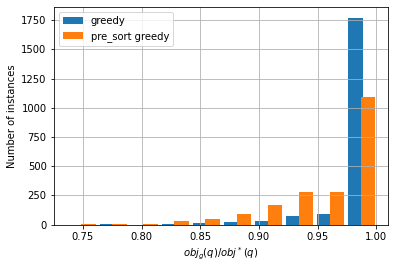

In [44]:
plt.hist([ratio_pn1e_1, ratio_pre1e_1], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn1e_1.pdf")

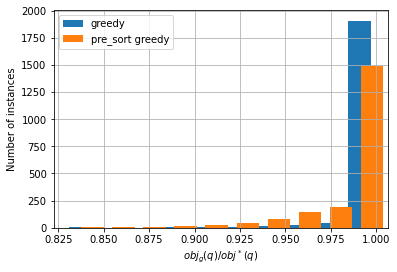

In [45]:
plt.hist([ratio_pn1, ratio_pre1], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn1e0.pdf")

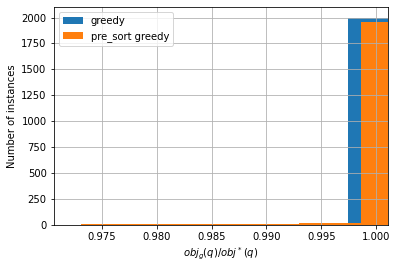

In [46]:
plt.hist([ratio_pn10, ratio_pre10], label=['greedy', 'pre_sort greedy'], **kwargs)
plt.grid()
plt.legend()
plt.ylabel("Number of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn10.pdf")

In [47]:
1/0
# Stop here

ZeroDivisionError: division by zero

In [ ]:
plt.hist([ratio], label=['greedy (ps)'], histtype='bar', log=True, density=True)
plt.grid()
# plt.legend()
plt.ylabel("Density of instances")
plt.xlabel(r"$obj_{g}(q)/obj^*(q)$")
plt.savefig("greedy_pn.pdf")

In [ ]:
ratio_greedy.min()

In [ ]:
plt.hist(ratio_greedy)

In [ ]:
smaller_instances_ref_greedy_res = []

for inst in smaller_instances:
    res1 = best_in_greedy(inst, f=grad_sum_by_orth_norm)
    res2 = best_in_greedy(inst, f=neg_grad_sum_by_orth_norm)
    res = res1 if res1.f_star >= res2.f_star else res2
    res.f_star = res.f_star**2
    smaller_instances_ref_greedy_res.append(res)

In [ ]:
import math

def compare_results_by_score(inst, *results):
    for res in results:
        res.print_selected_elements_by_score(end=': ')
        print(f'{res.f_star}')

subopt_instances = []
subopt_relgaps = []
for i, (inst, res_bf, res_greedy) in enumerate(zip(smaller_instances, smaller_instances_bf_res, smaller_instances_ref_greedy_res)):
    if not math.isclose(res_bf.f_star, res_greedy.f_star):
        gap = (res_bf.f_star - res_greedy.f_star)/res_bf.f_star
        # print('refined greedy suboptimal on instance', i, 'by', gap)
        subopt_instances.append(i)
        subopt_relgaps.append(gap)
        # compare_results_by_score(inst, res_bf, res_greedy)
    # plot_solutions(smaller_instances_bf_res[0])

subopt_instances = np.array(subopt_instances)
subopt_relgaps = np.array(subopt_relgaps)

print(len(subopt_instances), 'instances where greedy is suboptimal')
order = np.argsort(subopt_relgaps)[::-1]
print('the 10 most severe are: ')
print(subopt_instances[order[:10]])
print(subopt_relgaps[order[:10]])

In [ ]:
inst, res_bf, res_greedy = smaller_instances[10], smaller_instances_bf_res[10], smaller_instances_ref_greedy_res[10]
compare_results_by_score(inst, res_bf, res_greedy)
plot_solutions(smaller_instances_bf_res[10], additional_res=[res_greedy])


In [ ]:
res_greedy_neg = best_in_greedy(inst, f=neg_grad_sum_by_orth_norm)
res_greedy_neg.print_selected_elements_by_score()
print(res_greedy_neg.f_star**2)
print(norm(inst.M.dot(res_greedy_neg.q_star)))
print(norm(inst.M.dot(res_bf.q_star)))

In [ ]:
plot_solutions(smaller_instances_bf_res[69], [smaller_instances_ref_greedy_res[69]])

In [ ]:
plot_solutions(smaller_instances_bf_res[3], [smaller_instances_ref_greedy_res[3]])

### Intermediate Conclusion

Despite an overall very good performance, it seems that the refined greedy algorithm does not guarantee to find the optimal solution. Eight of the 30/100 optimality violations can be attributed to numerical instability where the optimal solution is either incorrect or at least pointing to a weaknesses of the objective function itself. The other 22 appear to be genuine problems with the largest relative performance gap of about 11%.

In any case, the numerical instability motivates regularising the objective function, and it is a possibility that such regularization will also further improve the performance of the greedy algorithm outside of strictly pathological instances.

## Regularised Objective Function

Because we are interested int the signed version of the objective function for the greedy algorithm, it makes sense to apply regularization to the non-squared version:

\begin{align*}
\frac{|g^Tq|}{\|q_\perp\|+\epsilon} &\leq \frac{|g^q|}{|g^Tq|/\|g\| + \epsilon}\\
&= \frac{\|g\|}{1 + \epsilon \|g\| / |g^Tq|}
\end{align*}


## Old

In [ ]:
def compare_results_by_score(inst, res):
    res.print_selected_elements_by_score(end=': ')
    print(f'{res.f_star}')
    res1 = best_in_greedy(inst)
    res1.print_selected_elements_by_score(end=': ')
    print(res1.f_star)
    res2 = best_in_greedy(inst, f=grad_sum_by_orth_norm)
    res2.print_selected_elements_by_score(end=': ')
    print(squared_grad_sum_by_squared_orth_norm(res2.q_star, inst))
    res3 = best_in_greedy(inst, f=neg_grad_sum_by_orth_norm)
    res3.print_selected_elements_by_score(end=': ')
    print(squared_grad_sum_by_squared_orth_norm(res3.q_star, inst))
    print()

for i, (inst, bf_res) in zip(smaller_instances, smaller_instances_bf_res):
    compare_results_by_score(inst, res)

In [ ]:
inst = smaller_instances[1]
for i in range(0, inst.n+1):
    res = best_in_greedy(inst)
    inst.print_selected_elements_by_score(res.q_seq[i], end=': ')
    print(squared_grad_sum_by_squared_orth_norm(res.q_seq[i], inst))

In [ ]:
from matplotlib import pyplot as plt

def plot_solutions(inst):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, tight_layout=True, squeeze=False)
    bf_obj_ = inst.bf_gsum_**2 / inst.bf_opn_**2
    axs[0, 0].scatter(inst.bf_norms_**2, bf_obj_)
    axs[0, 1].scatter(inst.bf_opn_**2, bf_obj_)
    axs[0, 2].scatter(inst.bf_gsum_, bf_obj_)
    axs[0, 0].scatter(norm(inst.q_star)**2, inst.obj_star, edgecolors='red', facecolors='none', label=r'$q^*$')
    axs[0, 1].scatter(norm(inst.M.dot(inst.q_star))**2, inst.obj_star, edgecolors='red', facecolors='none')
    axs[0, 2].scatter(inst.q_star.dot(inst.g), inst.obj_star, edgecolors='red', facecolors='none')
    axs[0, 0].set_ylabel(r'$(q^Tg)^2/\|q_\perp\|^2$')
    axs[0, 0].set_xlabel(r'$\|q\|^2$')
    axs[0, 1].set_xlabel(r'$\|q_\perp\|^2$')
    axs[0, 2].set_xlabel(r'$q^Tg$')
    axs[0, 0].axhline(norm(inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 1].axhline(norm(inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 2].axhline(norm(inst.g)**2, label='$\|g\|^2$', linestyle='--', color='red')
    axs[0, 0].legend(loc='upper right')

plot_solutions(inst1)
plt.show()

In [ ]:
plot_solutions(smaller_instances[3])

In [ ]:
R = np.triu(np.ones(shape=(n, n)))
(M.dot(R)**2).sum(axis=0)

In [ ]:
(M.dot(np.eye(n))**2).sum(axis=0)

In [ ]:
order = np.argsort(((np.eye(n) - O.dot(O.T)).dot(np.eye(n))**2).sum(axis=0))
order

In [ ]:
point_orth_scores = (M.dot(np.eye(n))**2).sum(axis=0)
point_orth_scores

In [ ]:
point_par_scores = (P.dot(np.eye(n))**2).sum(axis=0)
point_par_scores

In [ ]:
R = np.cumsum(np.eye(n)[order, :], axis=0).T
R[:, : 4]

In [ ]:
(M.dot(R)**2).sum(axis=0)

In [ ]:
g

In [ ]:
order = np.argsort(g)[::-1]
g[order]

In [ ]:
R = np.cumsum(np.eye(n)[order, :], axis=0).T
R[:, : 4]

In [ ]:
def prefix_matrix(order):
    return np.cumsum(np.eye(n)[order, :], axis=0).T

def obj_values_of_prefixes(order):
    R = prefix_matrix(order)
    return g.dot(R)**2 / (M.dot(R)**2).sum(axis=0)

In [ ]:
def squared_proj_length(queries):
    return (M.dot(queries)**2).sum(axis=0)

In [ ]:
def obj(queries):
    return g.dot(queries)**2 / squared_proj_length(queries)

In [ ]:
from itertools import combinations

def non_empty_subset_indicator(d, idx=None):
    idx = np.arange(d) if idx is None else idx
    for l in range(1, len(idx)+1):
        for c in combinations(idx, l):
            col = np.zeros(d)
            col[list(c)] = 1
            yield col

def non_empty_subset_matrix(d, idx=None):
    idx = np.arange(d) if idx is None else idx
    res = np.zeros(shape=(d, 2**len(idx)-1))
    j = 0
    for l in range(1, len(idx)+1):
        for c in combinations(idx, l):
            col = np.zeros(d)
            col[list(c)] = 1
            res[:, j] = col
            j+= 1
    return res

In [ ]:
# bfc_spl = squared_proj_length(bfc)
# g_sum = g.dot(bfc)

bfcg_gsum = np.zeros(2**n-1)
bfcg_spl = np.zeros(2**n-1)

for i, q in enumerate(non_empty_subset_indicator(20)):
    bfcg_gsum[i]=g.dot(q)
    bfcg_spl[i]=squared_proj_length(q)
    

In [ ]:
from matplotlib import pyplot as plt

bfc = non_empty_subset_matrix(n)
bfc_spl = squared_proj_length(bfc)
bfc_gsum = g.dot(bfc)
plt.scatter(bfc_spl[:], bfc_gsum[:]**2/bfc_spl[:], alpha=0.5)
plt.show()

In [ ]:
bfc_obj = bfc_gsum**2 / bfc_spl
np.argmax(bfc_obj)

In [ ]:
(bfcg_spl - bfc_spl).max()

In [ ]:
bfc_obj[np.argmax(bfc_obj)]

In [ ]:
q_max = bfc[:, np.argmax(bfc_obj)]
q_max

In [ ]:
np.flatnonzero(q_max)

In [ ]:
g[np.flatnonzero(q_max)]

In [ ]:
q_max_ = np.copy(q_max)
q_max_[7] = 0
q_max_

In [ ]:
g[np.flatnonzero(q_max_)].sum()**2

In [ ]:
g.dot(q_max)**2, squared_proj_length(q_max), g.dot(q_max)**2/squared_proj_length(q_max)

In [ ]:
g.dot(q_max_)**2, squared_proj_length(q_max_), g.dot(q_max_)**2/squared_proj_length(q_max_)

In [ ]:
np.sort(g[np.flatnonzero(bfc[:, np.argmax(bfc_obj)])])

In [ ]:
np.sort(g)

In [ ]:
norm(g)**2

In [ ]:
i_min_spl = np.argmin(bfc_spl)
i_min_spl

In [ ]:
q_min_spl = bfc[:, i_min_spl]
q_min_spl

In [ ]:
(M.dot(q_min_spl)**2).sum()

In [ ]:
g.dot(q_min_spl) / (M.dot(q_min_spl)**2).sum()

In [ ]:
g.dot(bfc)[i_min_spl]**2

In [ ]:
bfc_spl[np.argmin(bfc_spl[1:])]

In [ ]:
np.argmin(bfc_spl[1:])

In [ ]:
bfc_spl[1:][np.argmin(bfc_spl[1:])]

In [ ]:
M.dot(q_min)

In [ ]:
g.dot(bfc[:, np.argmin(bfc_spl[1:])])

In [ ]:
prefix_matrix(np.arange(4))

In [ ]:
g.dot(prefix_matrix(np.arange(10)))**2

In [ ]:
M.dot(prefix_matrix(np.arange(10)))

In [ ]:
g.dot(powerset_matrix(20))

In [ ]:
R = prefix_matrix(np.argsort(g)[::-1])
g.T.dot(R)**2 / (M.dot(R)**2).sum(axis=0)

In [ ]:
obj_values_of_prefixes(np.argsort(g)[::-1])

In [ ]:
from itertools import combinations

def non_empty_subset_matrix(d, idx=None):
    idx = np.arange(d) if idx is None else idx
    res = np.zeros(shape=(d, 2**len(idx)-1))
    j = 0
    for l in range(1, len(idx)+1):
        for c in combinations(idx, l):
            col = np.zeros(d)
            col[list(c)] = 1
            res[:, j] = col
            j+= 1
    return res

non_empty_subset_matrix(20, np.arange(10)).shape

In [ ]:
(M.dot(prefix_matrix(np.argsort(point_orth_scores)[::-1]))**2).sum(axis=0)

In [ ]:
obj_values_of_prefixes(np.argsort(g)[::-1])

In [ ]:
plt.plot(obj_values_of_prefixes(np.argsort(g)[::-1]))

In [ ]:
obj_values_of_prefixes(np.argsort(g / point_orth_scores)[::1])

In [ ]:
plt.plot(obj_values_of_prefixes(np.argsort(g / point_orth_scores)[::1]))

In [ ]:
plt.plot(obj_values_of_prefixes(np.argsort(g)[::-1]))
plt.plot(obj_values_of_prefixes(np.argsort(g*point_par_scores / point_orth_scores)[::1]), label='$ge_\par/$')
plt.plot(obj_values_of_prefixes(np.argsort(g / point_orth_scores)[::1]))
plt.legend()

In [ ]:
g[np.argsort(g)[::-1]]

In [ ]:
g.dot(prefix_matrix(np.argsort(g)[::-1]))

In [ ]:
prefix_matrix(np.arange(n))[:,:4]

In [ ]:
denom = (M.dot(R)**2).sum(axis=0)
denom

In [ ]:
g.dot(R), np.cumsum(g[order])

In [ ]:
obj_values_of_prefixes(np.argsort(g)[::-1])

In [ ]:
(g / point_orth_scores**0.5)[np.argsort(g / point_orth_scores**0.5)[::-1]]

In [ ]:
obj_values_of_prefixes(np.argsort(g / point_par_scores)[::-1])

In [ ]:
g.dot(R)/denom

In [ ]:
O.T.dot(O)

In [ ]:
G = Q.T.dot(Q)
G

In [ ]:
G_inv = np.linalg.inv(G)
G_inv

In [ ]:
q1 = RNG.binomial(1, 0.8, size=20)
q2 = RNG.binomial(1, 0.2, size=20)
q1, q2

In [ ]:
def decomp(Q, q):
    G = Q.T.dot(Q)
    G_inv = np.linalg.inv(G)
    q_proj = Q.dot(G_inv.dot(Q.T.dot(q)))
    return q_proj, q-q_proj

In [ ]:
np.linalg.norm(q1)**2

In [ ]:
from numpy.linalg import norm

q1_par, q1_orth = decomp(Q, q1)
q2_par, q2_orth = decomp(Q, q2)

norm(q1_par), norm(q2_par)

In [ ]:
q1_par, q1_orth

In [ ]:
r = 1000
covs = np.zeros(r)
par_norms = np.zeros(r)
orth_norms = np.zeros(r)

for i in range(r):
    q = RNG.binomial(1, 0.5, 20)
    covs[i] = sum(q)
    q1_par, q1_orth = decomp(Q, q)
    par_norms[i] = norm(q1_par)
    orth_norms[i] = norm(q1_par)

norms = covs**0.5


In [ ]:
q_all_par, q_all_orth = decomp(Q, np.ones(20))

In [ ]:
from matplotlib import pyplot as plt

plt.scatter(norms, par_norms)
plt.scatter([norm(np.ones(20))], [norm(q_all_par)])
plt.plot([1, 4.6], [1, 4.6])
plt.margins(x=0, y=0)
plt.ylabel('$\|q_\parallel\|$')
plt.xlabel('$\|q\|$')
plt.show()